In [1]:
import midynet
import midynet.util.display as display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pathlib
from thresholds import *

display.setup_dir("./")

plot = midynet.metrics.Statistics.plot

paths_to_figures = [".", "../../../../papers/p-midynet/paper1-mutual_info/figures"]
paths_to_figures = list(map(pathlib.Path, paths_to_figures))
path_to_data = pathlib.Path("../../../../data/midynet-data/figure4")

In [3]:
exp = {}
hg, hx, hgx, hxg, mi = {}, {}, {}, {}, {}
thresholds = {}
T = 100

all_dynamics = ["ising", "sis", "cowan"]
for dynamics in all_dynamics:
    path = path_to_data / f"figure4-nbinom-{dynamics}.num_steps{T}"
    if (path / "config.pickle").exists():
        exp[dynamics] = midynet.experiments.Experiment.load_from_file(path / "config.pickle")
        hg[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hg-{k}"] for k in ["mid", "high", "low"]})
        hx[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hx-{k}"] for k in ["mid", "high", "low"]})
        hgx[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hgx-{k}"] for k in ["mid", "high", "low"]})
        hxg[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hxg-{k}"] for k in ["mid", "high", "low"]})
        mi[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"mi-{k}"] for k in ["mid", "high", "low"]})
    N, E = exp[dynamics].config.graph.size, exp[dynamics].config.graph.edge_count.state
    heterogeneity = exp[dynamics].config.graph.heterogeneity
    avgk = [midynet.util.degree_sequences.nbinom_degreeseq(N, 2 * E / N, h).mean() for h in heterogeneity]
    if dynamics == "ising" or dynamics == "sis":
        thresholds[dynamics] = avgk / dominant_eigenvalue(exp[dynamics].config.graph)
    else:
        a = exp[dynamics].config.dynamics.a
        b = exp[dynamics].config.dynamics.eta
        m = exp[dynamics].config.dynamics.mu
        thresholds[dynamics], _ = wc_thresholds(a=a, b=b, m=m)
        thresholds[dynamics] *= avgk / dominant_eigenvalue(exp[dynamics].config.graph)
    

titles = {"ising": r"Glauber", "sis": r"SIS", "cowan": r"Cowan"}
xlabels = {"ising": r"Coupling $J\langle k \rangle$", "sis": r"Infection rate $\lambda \langle k \rangle$", "cowan": r"Activity gain $\nu\langle k \rangle$"}

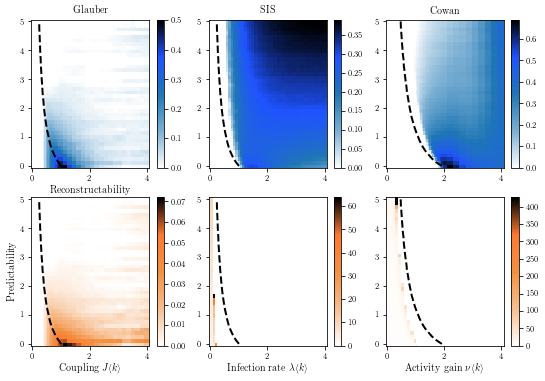

In [11]:
SCALE=1
fig, ax = plt.subplots(2, 3, figsize=(SCALE*9, SCALE*6))

recon_cmap = display.palettes["blues"].mpl_colormap
pred_cmap = display.palettes["oranges"].mpl_colormap

for i, dynamics in enumerate(all_dynamics):
    g_params = exp[dynamics].config.graph.heterogeneity
    d_params = exp[dynamics].config.dynamics.get_coupling()
    if dynamics == "sis":
        d_params = [pp / exp[dynamics].config.dynamics.recovery_prob for pp in d_params]
    recon = mi[dynamics] / hg[dynamics]
    GP, DP = np.meshgrid(g_params, d_params)
    p_recon = ax[0, i].pcolor(
        DP, GP,
        recon["mid"], 
        cmap=recon_cmap, 
        shading="auto",
        vmin=0,
        vmax=np.max(recon["mid"]),
    )
    ax[0, i].plot(thresholds[dynamics], g_params, "k--", linewidth=2)
    ax[0, i].set_title(titles[dynamics], fontsize=display.fontsizes["large"])
    if i == 0:
        ax[0, i].set_xlabel(r"Reconstructability", fontsize=display.fontsizes["large"])
        
    fig.colorbar(p_recon, ax=ax[0,i])
    
    pred = mi[dynamics] / hx[dynamics]
    p_pred = ax[1, i].pcolor(
        DP, GP,
        pred["mid"], 
        cmap=pred_cmap, 
        shading="auto",
        vmin=0,
    )
    ax[1, i].plot(thresholds[dynamics], g_params, "k--", linewidth=2)
    ax[1, i].set_xlabel(xlabels[dynamics], fontsize=display.fontsizes["large"])
    fig.colorbar(p_pred, ax=ax[1,i])
    if i == 0:
        ax[1, i].set_ylabel("Predictability", fontsize=display.fontsizes["large"])
    
#     p_pred = ax[2, i].pcolor(
#         DP, GP,
#         mi[dynamics]["mid"], 
#         cmap=pred_cmap, 
#         shading="auto",
#         vmin=0,
#     )
#     ax[2, i].plot(thresholds[dynamics], g_params, "k--", linewidth=2)
#     ax[2, i].set_xlabel(xlabels[dynamics], fontsize=display.fontsizes["large"])
#     fig.colorbar(p_pred, ax=ax[2,i])
#     if i == 0:
#         ax[2, i].set_ylabel("Mutual information", fontsize=display.fontsizes["large"])
    


In [43]:
mi["ising"]["mid"].max()

1169.3401225528487

In [15]:
midynet

<module 'midynet' from '/home/charles_murphy/Documents/ulaval/doctorat/projects/codes/fast-midynet/midynet/__init__.py'>